## Decision trees and random forests

In [1]:
#Create a decision tree classifier. Tune its depth and plot the validation curve.

import numpy as np
import pandas as pd

with np.load('cifar4-train.npz', allow_pickle = False) as npz_file:
    cifar4_data = dict(npz_file.items())
    
print(list(cifar4_data.keys()))


X = cifar4_data['overfeat']
y = cifar4_data['labels']

print('X:', X.shape, X.dtype)
print('y:', y.shape, y.dtype)

['pixels', 'overfeat', 'labels', 'names', 'allow_pickle']
X: (5000, 4096) float32
y: (5000,) int64


In [2]:
from sklearn.model_selection import train_test_split

# Convert the type of the input matrix to float
X = X.astype(np.float)

# Split data into train/test sets, keeping same proportion of classes
X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=4000, test_size=1000, random_state=0, stratify=y)

print ('Train set:', X_tr.shape, y_tr.shape)
print('Test set:', X_te.shape, y_te.shape)

Train set: (4000, 4096) (4000,)
Test set: (1000, 4096) (1000,)


In [3]:
#Split the train set into a (smaller) train and validation sets with respectively 3,200 and 800 points.

X_tr_s, X_val, y_tr_s, y_val = train_test_split(X_tr, y_tr, train_size=3200, test_size=800, random_state=0, stratify=y_tr)

print('Small train set:', X_tr_s.shape, y_tr_s.shape)
print('Validation set:', X_val.shape, y_val.shape)

Small train set: (3200, 4096) (3200,)
Validation set: (800, 4096) (800,)


In [4]:
#Decision tree classifier

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=0)


# use PCA as a preprocessing step as number of features is large it seems reasonable to reduce number of dimensions 
    #and make data less redundant
    
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_tr_s_stand = scaler.fit_transform(X_tr_s)
X_val_stand = scaler.transform(X_val)

pca = PCA(n_components = 60) #keep 80% PVE
pca.fit(X_tr_s_stand, y=None)

X_tr_s_reduced = pca.transform(X_tr_s_stand)
X_val_reduced = pca.transform(X_val_stand)


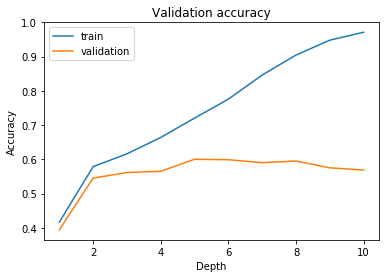

In [5]:
#Tune the depth parameter using grid search and plot the validation curve as described. Write your observations.

depths = np.arange(1, 11)

train_curve = []
validation_curve = []

for d in depths:
    dt = DecisionTreeClassifier(criterion='gini', max_depth = d, random_state=0)
    dt.fit(X_tr_s_stand, y_tr_s)

    train_acc = dt.score(X_tr_s_stand, y_tr_s)
    validation_acc = dt.score(X_val_stand, y_val)
    
    train_curve.append(train_acc)
    validation_curve.append(validation_acc)


%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(depths, train_curve, label='train')
plt.plot(depths, validation_curve, label='validation')
plt.legend()
plt.title('Validation accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()

Both train and validation curves are improving 'together' between 0 and 2, then train curve keeps increasing, which is sign of overfitting, while validation curve reaches a plateau.

In [6]:
dt_df = pd.DataFrame({'max_depth':depths, 'accuracy_train':train_curve, 'accuracy_validation':validation_curve})
dt_df.sort_values(by='accuracy_validation', ascending=False)

,accuracy_train,accuracy_validation,max_depth
4,0.720313,0.60000,5
5,0.775625,0.59875,6
7,0.904375,0.59500,8
6,0.845938,0.59000,7
8,0.947812,0.57500,9
9,0.970938,0.56875,10
3,0.663750,0.56500,4
2,0.615938,0.56125,3
1,0.578438,0.54500,2
0,0.416250,0.39375,1


In [7]:
#Find the depth with the best validation accuracy and print it.
idx = np.argmax(validation_curve)
top_accuracy = validation_curve[idx]
dep = depths[idx]
print('Top accuracy on validation set: {:.2f} with depth={}'.format(top_accuracy, dep))

Top accuracy on validation set: 0.60 with depth=5


#### Create a random forest classifier. Try different sizes of ensemble.

In [10]:
#Create a random forest classifier. Try different sizes of ensemble.

from sklearn.ensemble import RandomForestClassifier

values = np.arange(50, 251, 50)
accuracy = []

for value in values:
    rf = RandomForestClassifier(n_estimators=value, max_depth=None, random_state=0)
    rf.fit(X_tr_s_stand, y_tr_s)
    
    acc= rf.score(X_val_stand, y_val)
    accuracy.append(acc)

In [20]:
#Collect the results in a DataFrame.

results_df = pd.DataFrame({'n_estimators':values, 'validation accuracy':accuracy})

results_df.sort_values(by='validation accuracy', ascending=False)

,n_estimators,validation accuracy
1,100,0.79250
3,200,0.79000
4,250,0.78625
2,150,0.78500
0,50,0.76250


###### Finally, fit your (tuned) decision tree and random forest estimators on the entire train set with 4,000 data points and evaluate them on the test set. Print the accuracy values.

In [21]:
#decision tree
dt_tuned = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=0)

dt_tuned.fit(X_tr, y_tr)
dt_accuracy=dt_tuned.score(X_te, y_te)


In [22]:
#random forest
rf_tuned = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=0)

rf_tuned.fit(X_tr, y_tr)
rf_accuracy = rf_tuned.score(X_te, y_te)

In [23]:
print('Decision tree accuracy (test set):', dt_accuracy)
print('Random forest accuracy (test set):', rf_accuracy)

Decision tree accuracy (test set): 0.658
Random forest accuracy (test set): 0.791
